In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/processed/2023_pace_laps_with_delta_phase.csv")

In [3]:
race = "Bahrain Grand Prix"
driver = "VER"

In [4]:
plot_df = df[
    (df["RaceName"] == race) &
    (df["Driver"] == driver)
].sort_values("LapNumber")

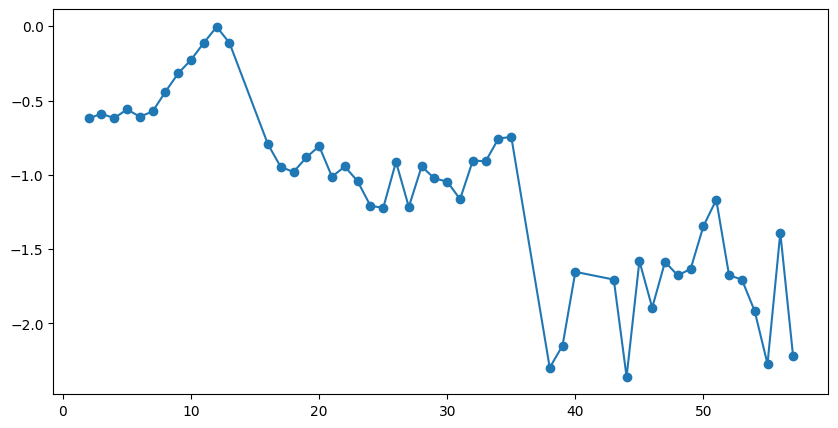

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(
    plot_df["LapNumber"],
    plot_df["LapDelta_seconds"],
    marker="o"
)

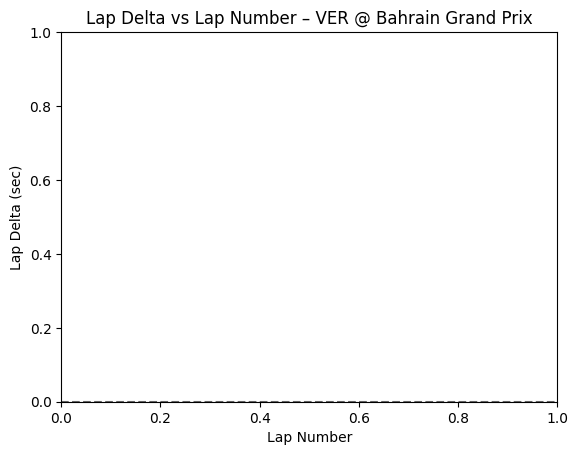

In [6]:
plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.xlabel("Lap Number")
plt.ylabel("Lap Delta (sec)")
plt.title(f"Lap Delta vs Lap Number – {driver} @ {race}")
plt.show()

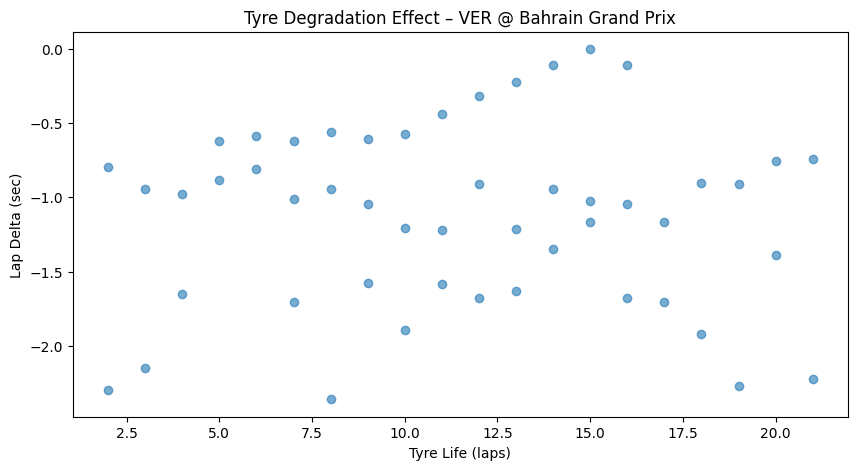

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(
    plot_df["TyreLife"],
    plot_df["LapDelta_seconds"],
    alpha=0.6
)
plt.xlabel("Tyre Life (laps)")
plt.ylabel("Lap Delta (sec)")
plt.title(f"Tyre Degradation Effect – {driver} @ {race}")
plt.show()


In [11]:
import pandas as pd
import numpy as np
import joblib

# Load data
df = pd.read_csv("../data/processed/2023_pace_laps_with_delta_phase.csv")

# Load final model
model = joblib.load("../models/lap_delta_random_forest_prelap_phase.pkl")

FEATURES = [
    "TyreLife",
    "TyreLifeSquared",
    "LapInStint",
    "LapNumber",
    "Stint",
    "Compound_encoded",
    "Driver_encoded",
    "Team_encoded",
    "FuelProxy",
    "RaceProgress",
]

pit_loss_seconds = 22.0


In [12]:
def predict_lap_delta(row):
    X = pd.DataFrame([row[FEATURES]], columns=FEATURES)
    return model.predict(X)[0]


def simulate_race_driver(race_df, driver, pit_lap):
    driver_df = race_df[race_df["Driver"] == driver].sort_values("LapNumber")

    total_delta = 0.0

    for _, row in driver_df.iterrows():
        if row["LapNumber"] < pit_lap:
            total_delta += predict_lap_delta(row)

        elif row["LapNumber"] == pit_lap:
            total_delta += predict_lap_delta(row) + pit_loss_seconds

        else:
            new_row = row.copy()
            new_row["TyreLife"] = row["LapNumber"] - pit_lap + 1
            new_row["TyreLifeSquared"] = new_row["TyreLife"] ** 2
            new_row["LapInStint"] = new_row["TyreLife"]
            total_delta += predict_lap_delta(new_row)

    return total_delta


In [13]:
race = "Bahrain Grand Prix"
driver = "VER"

race_df = df[
    (df["RaceName"] == race) &
    (df["Driver"] == driver)
].sort_values("LapNumber")

max_lap = int(race_df["LapNumber"].max())

results = []

# Narrow window for speed
for pit_lap in range(15, max_lap - 15):
    total_delta = simulate_race_driver(race_df, driver, pit_lap)
    results.append({
        "PitLap": pit_lap,
        "TotalLapDelta": total_delta
    })

results_df = pd.DataFrame(results)
results_df.head()


,PitLap,TotalLapDelta
0,15,-55.504092
1,16,-34.107904
2,17,-34.556318
3,18,-34.657523
4,19,-34.525055


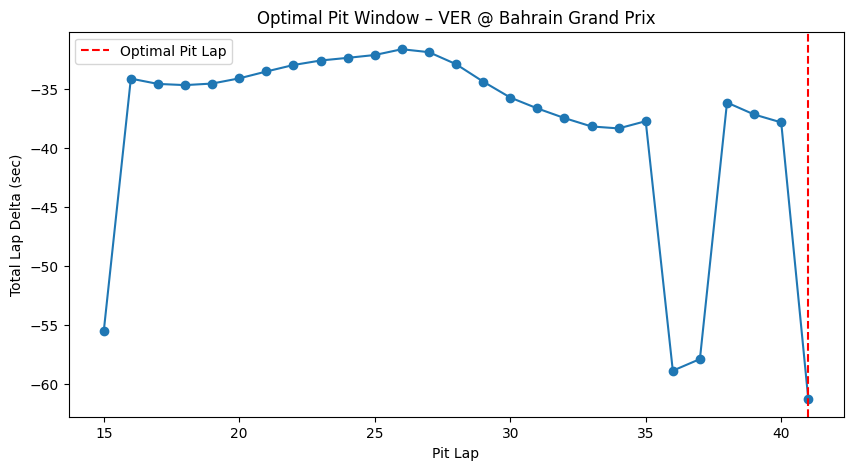

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df["PitLap"], results_df["TotalLapDelta"], marker="o")
plt.axvline(
    results_df.loc[results_df["TotalLapDelta"].idxmin(), "PitLap"],
    color="red",
    linestyle="--",
    label="Optimal Pit Lap"
)
plt.xlabel("Pit Lap")
plt.ylabel("Total Lap Delta (sec)")
plt.title(f"Optimal Pit Window – {driver} @ {race}")
plt.legend()
plt.show()


In [15]:
optimal_row = results_df.loc[results_df["TotalLapDelta"].idxmin()]
optimal_row

PitLap           41.000000
TotalLapDelta   -61.265405
Name: 26, dtype: float64

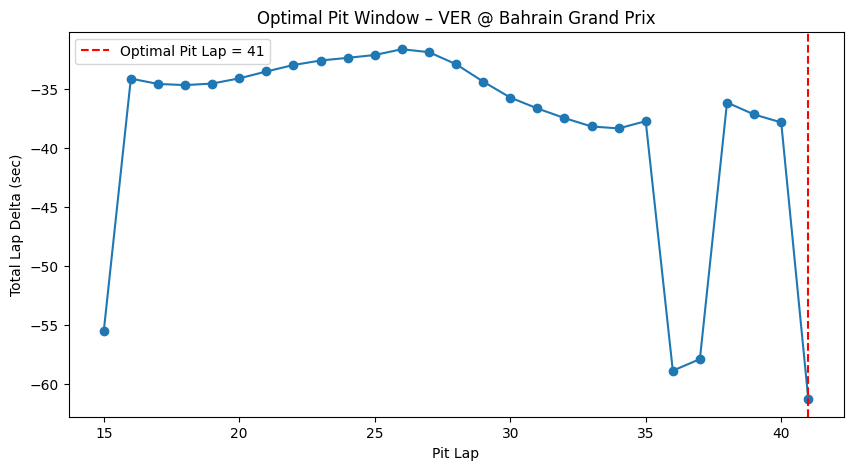

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df["PitLap"], results_df["TotalLapDelta"], marker="o")
plt.axvline(
    optimal_row["PitLap"],
    color="red",
    linestyle="--",
    label=f"Optimal Pit Lap = {int(optimal_row['PitLap'])}"
)
plt.xlabel("Pit Lap")
plt.ylabel("Total Lap Delta (sec)")
plt.title(f"Optimal Pit Window – {driver} @ {race}")
plt.legend()
plt.show()
